In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

Імпортуємо дані, що використовувалися в 4 лабораторній роботі

In [2]:
import hub

ds = hub.load("hub://activeloop/kuzushiji-kanji")

/home/nerbivol/.local/lib/python3.10/site-packages/hub/util/check_latest_version.py:32: UserWarning: A newer version of hub (2.5.2) is available. It's recommended that you update to the latest version using `pip install -U hub`.
  warnings.warn(


hub://activeloop/kuzushiji-kanji loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/kuzushiji-kanji


Використаємо лише частину даних для навчання

In [3]:
X = ds.images[:800].numpy() 
Y = ds.labels[:800].numpy()
np.unique(Y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint32)

Також варто звернути увагу на те, що серед цих даний є значно переважаючий, по кількості прикладів, клас номер 3 та менш переважаючий клас 8 відносно інших.

In [4]:
for i in range(13):
    arr = np.where(Y==i)[0]
    print(i,":", len(arr))

0 : 5
1 : 4
2 : 2
3 : 552
4 : 11
5 : 5
6 : 6
7 : 2
8 : 153
9 : 34
10 : 17
11 : 4
12 : 5


Проблема полягає в тому, що такий набір не є ефективним для пошуку класів. Наприклад, навчання автокодера на наборі даних при візуалізації кодування з 2D прихованого простору виявляє утворення окремих кластерів. Це має сенс, оскільки окремі кодування для кожного типу зображень значно полегшують роботу при їх декодування. </br>

Але коли ми створюєте генеративну модель, ми не хочемо взяти те саме зображення яке ми ввели. Ми хочемо випадково відбирати вибірку з прихованого простору або генерувати варіації вхідного зображення з безперервного прихованого простору. </br>
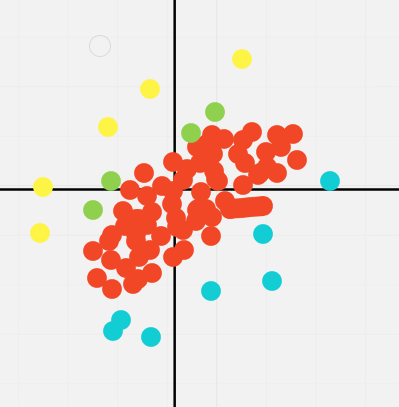
І при випадку таких даних, як вище отримаємо ситуацію, що серед даних буде віділятися один клас. Так як деякі класи поглинуться іншим більшим класом, а інші будуть сприяматися як шум.
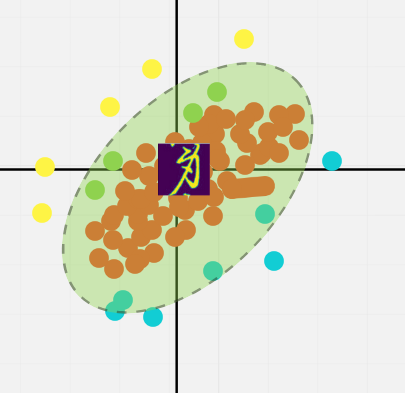

І латентний простір буде складатися з чисел лише одного класу з можливими незначними відмінностями по краям латентного простору. В даному випадку матимемо латентний простір повністю заповнений символом схожим на клас 3

Для того, щоб позбутися такого дефекту потрібно нормалізувати по кількості наш набір даних.

In [5]:
index = range(18,563)
X = np.delete(X, index, axis=0)
Y = np.delete(Y, index,axis=0)

index = range(48,193)
X = np.delete(X, index, axis=0)
Y = np.delete(Y, index, axis=0)

index = range(57,83)
X = np.delete(X, index, axis=0)
Y = np.delete(Y, index, axis=0)

In [6]:
for i in range(13):
    arr = np.where(Y==i)[0]
    print(i,":", len(arr))

0 : 5
1 : 4
2 : 2
3 : 7
4 : 11
5 : 5
6 : 6
7 : 2
8 : 8
9 : 8
10 : 17
11 : 4
12 : 5


Оримали набір даних з яким можна продовжувати роботу.

Тепер ми можемо перейти до визначення самої моделі Variation Autoencoder Keras. Для початку ми визначаємо мережу кодування, яка являє собою просту послідовність згорткових шарів

In [7]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 16384)        0           ['conv2d_1[0][0]']               
                                                                                            

2022-06-08 21:52:52.295494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 21:52:52.332319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-08 21:52:52.332342: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-08 21:52:52.332698: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [8]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 16384)             49152     
                                                                 
 reshape (Reshape)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 1)         289 

In [27]:
## Код даного класу було взято з підручника "François Chollet - Deep Learning with Python"

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
            grads = tape.gradient(total_loss, self.trainable_weights)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            }
            

In [11]:
def plot_datasethead(X, Y, n=6):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        arr = np.where(Y==i)[0]
        index = arr[np.random.randint(len(arr))]
        plt.imshow(X[index])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        arr = np.where(Y==(i+5))[0]
        index = arr[np.random.randint(len(arr))] 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(X[index])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

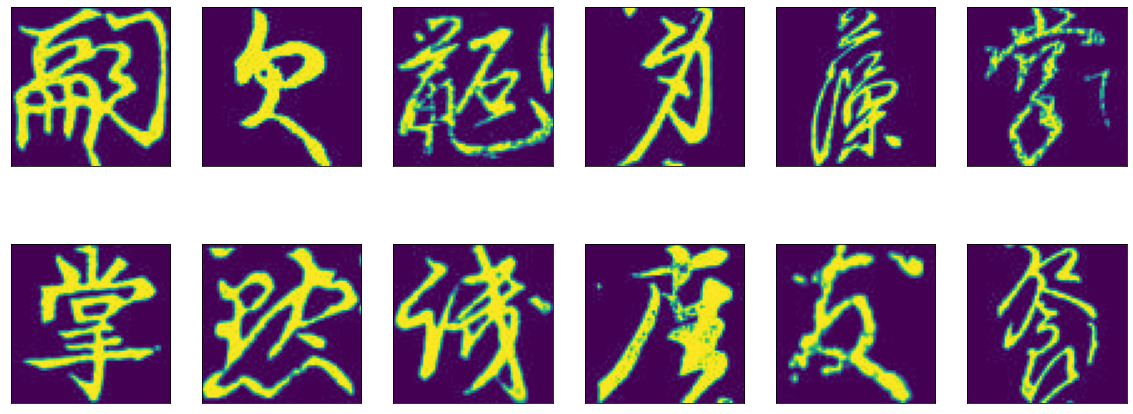

In [37]:
plot_datasethead(X,Y)

In [13]:
mnist_digits = np.expand_dims(X, -1).astype("float32") / 255

In [14]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=2000, batch_size=32)

Epoch 1/2000
3/3 [==============================] - 1s 187ms/step - total_loss: 2835.9993 - reconstruction_loss: 2835.9792 - kl_loss: 0.0182
Epoch 2/2000
3/3 [==============================] - 1s 190ms/step - total_loss: 2818.6790 - reconstruction_loss: 2818.6582 - kl_loss: 0.0203
Epoch 3/2000
3/3 [==============================] - 1s 199ms/step - total_loss: 2792.6516 - reconstruction_loss: 2792.5312 - kl_loss: 0.1066
Epoch 4/2000
3/3 [==============================] - 1s 182ms/step - total_loss: 2731.4080 - reconstruction_loss: 2730.3635 - kl_loss: 0.9244
Epoch 5/2000
3/3 [==============================] - 1s 188ms/step - total_loss: 2548.8108 - reconstruction_loss: 2540.4734 - kl_loss: 7.3713
Epoch 6/2000
3/3 [==============================] - 1s 193ms/step - total_loss: 2479.3738 - reconstruction_loss: 2414.5520 - kl_loss: 65.1550
Epoch 7/2000
3/3 [==============================] - 1s 187ms/step - total_loss: 2206.0437 - reconstruction_loss: 2182.5403 - kl_loss: 23.9403
Epoch 8/200

3/3 [==============================] - 1s 187ms/step - total_loss: 1617.8926 - reconstruction_loss: 1605.8335 - kl_loss: 11.4881
Epoch 116/2000
3/3 [==============================] - 1s 185ms/step - total_loss: 1645.8438 - reconstruction_loss: 1633.6559 - kl_loss: 12.3780
Epoch 117/2000
3/3 [==============================] - 1s 178ms/step - total_loss: 1656.9310 - reconstruction_loss: 1645.2277 - kl_loss: 12.0442
Epoch 118/2000
3/3 [==============================] - 1s 180ms/step - total_loss: 1661.2106 - reconstruction_loss: 1649.1045 - kl_loss: 12.5733
Epoch 119/2000
3/3 [==============================] - 1s 190ms/step - total_loss: 1629.6744 - reconstruction_loss: 1617.5787 - kl_loss: 11.9430
Epoch 120/2000
3/3 [==============================] - 1s 187ms/step - total_loss: 1615.6984 - reconstruction_loss: 1602.8336 - kl_loss: 12.2675
Epoch 121/2000
3/3 [==============================] - 1s 171ms/step - total_loss: 1642.2183 - reconstruction_loss: 1630.4312 - kl_loss: 11.7720
Epoch 1

Epoch 172/2000
3/3 [==============================] - 1s 171ms/step - total_loss: 1561.5726 - reconstruction_loss: 1548.1974 - kl_loss: 13.1062
Epoch 173/2000
3/3 [==============================] - 1s 197ms/step - total_loss: 1555.8812 - reconstruction_loss: 1543.1664 - kl_loss: 12.8780
Epoch 174/2000
3/3 [==============================] - 1s 185ms/step - total_loss: 1580.1064 - reconstruction_loss: 1568.1504 - kl_loss: 12.1470
Epoch 175/2000
3/3 [==============================] - 1s 188ms/step - total_loss: 1556.4911 - reconstruction_loss: 1544.1276 - kl_loss: 12.4505
Epoch 176/2000
3/3 [==============================] - 1s 189ms/step - total_loss: 1559.4362 - reconstruction_loss: 1546.2350 - kl_loss: 12.9055
Epoch 177/2000
3/3 [==============================] - 1s 186ms/step - total_loss: 1565.5861 - reconstruction_loss: 1553.1788 - kl_loss: 12.7345
Epoch 178/2000
3/3 [==============================] - 1s 192ms/step - total_loss: 1552.7523 - reconstruction_loss: 1540.0480 - kl_loss: 

Epoch 285/2000
3/3 [==============================] - 1s 182ms/step - total_loss: 1416.2684 - reconstruction_loss: 1402.1432 - kl_loss: 14.1432
Epoch 286/2000
3/3 [==============================] - 1s 185ms/step - total_loss: 1410.7960 - reconstruction_loss: 1397.7378 - kl_loss: 13.2553
Epoch 287/2000
3/3 [==============================] - 1s 187ms/step - total_loss: 1430.0758 - reconstruction_loss: 1416.3700 - kl_loss: 13.7083
Epoch 288/2000
3/3 [==============================] - 1s 187ms/step - total_loss: 1414.7719 - reconstruction_loss: 1401.5758 - kl_loss: 13.5817
Epoch 289/2000
3/3 [==============================] - 1s 185ms/step - total_loss: 1427.8192 - reconstruction_loss: 1414.9923 - kl_loss: 13.0234
Epoch 290/2000
3/3 [==============================] - 1s 188ms/step - total_loss: 1419.0181 - reconstruction_loss: 1404.8102 - kl_loss: 14.1817
Epoch 291/2000
3/3 [==============================] - 1s 187ms/step - total_loss: 1439.3737 - reconstruction_loss: 1426.8805 - kl_loss: 

Epoch 398/2000
3/3 [==============================] - 1s 187ms/step - total_loss: 1310.4156 - reconstruction_loss: 1296.2114 - kl_loss: 14.5617
Epoch 399/2000
3/3 [==============================] - 1s 186ms/step - total_loss: 1296.9196 - reconstruction_loss: 1282.7948 - kl_loss: 14.3540
Epoch 400/2000
3/3 [==============================] - 1s 184ms/step - total_loss: 1318.3605 - reconstruction_loss: 1304.3683 - kl_loss: 14.4646
Epoch 401/2000
3/3 [==============================] - 1s 182ms/step - total_loss: 1300.7355 - reconstruction_loss: 1286.2546 - kl_loss: 14.8007
Epoch 402/2000
3/3 [==============================] - 1s 196ms/step - total_loss: 1316.6230 - reconstruction_loss: 1302.5685 - kl_loss: 14.0622
Epoch 403/2000
3/3 [==============================] - 1s 181ms/step - total_loss: 1314.3881 - reconstruction_loss: 1299.7140 - kl_loss: 14.8360
Epoch 404/2000
3/3 [==============================] - 1s 195ms/step - total_loss: 1312.9044 - reconstruction_loss: 1298.5311 - kl_loss: 

Epoch 511/2000
3/3 [==============================] - 1s 177ms/step - total_loss: 1216.5713 - reconstruction_loss: 1201.3986 - kl_loss: 15.3949
Epoch 512/2000
3/3 [==============================] - 1s 187ms/step - total_loss: 1203.6830 - reconstruction_loss: 1187.6260 - kl_loss: 15.6989
Epoch 513/2000
3/3 [==============================] - 1s 183ms/step - total_loss: 1236.4064 - reconstruction_loss: 1221.0996 - kl_loss: 15.4008
Epoch 514/2000
3/3 [==============================] - 1s 188ms/step - total_loss: 1202.6940 - reconstruction_loss: 1186.6710 - kl_loss: 15.6653
Epoch 515/2000
3/3 [==============================] - 1s 189ms/step - total_loss: 1231.1080 - reconstruction_loss: 1215.6958 - kl_loss: 15.5695
Epoch 516/2000
3/3 [==============================] - 1s 183ms/step - total_loss: 1217.4415 - reconstruction_loss: 1201.8182 - kl_loss: 15.4812
Epoch 517/2000
3/3 [==============================] - 1s 188ms/step - total_loss: 1215.7061 - reconstruction_loss: 1200.1654 - kl_loss: 

Epoch 624/2000
3/3 [==============================] - 1s 186ms/step - total_loss: 1155.1572 - reconstruction_loss: 1139.6552 - kl_loss: 15.7018
Epoch 625/2000
3/3 [==============================] - 1s 197ms/step - total_loss: 1151.5734 - reconstruction_loss: 1136.0420 - kl_loss: 15.4696
Epoch 626/2000
3/3 [==============================] - 1s 186ms/step - total_loss: 1150.8340 - reconstruction_loss: 1135.3019 - kl_loss: 15.6240
Epoch 627/2000
3/3 [==============================] - 1s 193ms/step - total_loss: 1138.1984 - reconstruction_loss: 1122.6752 - kl_loss: 15.5380
Epoch 628/2000
3/3 [==============================] - 1s 190ms/step - total_loss: 1160.0082 - reconstruction_loss: 1144.5067 - kl_loss: 15.4621
Epoch 629/2000
3/3 [==============================] - 1s 190ms/step - total_loss: 1137.6709 - reconstruction_loss: 1121.8571 - kl_loss: 15.7701
Epoch 630/2000
3/3 [==============================] - 1s 191ms/step - total_loss: 1160.9463 - reconstruction_loss: 1145.7408 - kl_loss: 

Epoch 737/2000
3/3 [==============================] - 1s 190ms/step - total_loss: 1111.0468 - reconstruction_loss: 1095.2645 - kl_loss: 16.3313
Epoch 738/2000
3/3 [==============================] - 1s 176ms/step - total_loss: 1112.6654 - reconstruction_loss: 1096.5546 - kl_loss: 16.1838
Epoch 739/2000
3/3 [==============================] - 1s 179ms/step - total_loss: 1106.7130 - reconstruction_loss: 1090.0381 - kl_loss: 16.4035
Epoch 740/2000
3/3 [==============================] - 1s 188ms/step - total_loss: 1104.3009 - reconstruction_loss: 1087.8339 - kl_loss: 16.1614
Epoch 741/2000
3/3 [==============================] - 1s 183ms/step - total_loss: 1107.2437 - reconstruction_loss: 1090.4835 - kl_loss: 16.3169
Epoch 742/2000
3/3 [==============================] - 1s 180ms/step - total_loss: 1123.6582 - reconstruction_loss: 1107.8256 - kl_loss: 16.0775
Epoch 743/2000
3/3 [==============================] - 1s 186ms/step - total_loss: 1101.3672 - reconstruction_loss: 1084.8420 - kl_loss: 

Epoch 850/2000
3/3 [==============================] - 1s 212ms/step - total_loss: 1080.3666 - reconstruction_loss: 1064.8911 - kl_loss: 15.5928
Epoch 851/2000
3/3 [==============================] - 1s 236ms/step - total_loss: 1069.0394 - reconstruction_loss: 1053.1810 - kl_loss: 15.8462
Epoch 852/2000
3/3 [==============================] - 1s 231ms/step - total_loss: 1066.2916 - reconstruction_loss: 1050.5575 - kl_loss: 15.7286
Epoch 853/2000
3/3 [==============================] - 1s 222ms/step - total_loss: 1056.2531 - reconstruction_loss: 1040.2260 - kl_loss: 15.8785
Epoch 854/2000
3/3 [==============================] - 1s 215ms/step - total_loss: 1067.8407 - reconstruction_loss: 1052.5073 - kl_loss: 15.8246
Epoch 855/2000
3/3 [==============================] - 1s 216ms/step - total_loss: 1049.7330 - reconstruction_loss: 1033.6494 - kl_loss: 15.7526
Epoch 856/2000
3/3 [==============================] - 1s 219ms/step - total_loss: 1057.9174 - reconstruction_loss: 1042.1304 - kl_loss: 

Epoch 963/2000
3/3 [==============================] - 1s 240ms/step - total_loss: 1032.4288 - reconstruction_loss: 1016.0173 - kl_loss: 16.3625
Epoch 964/2000
3/3 [==============================] - 1s 239ms/step - total_loss: 1027.1855 - reconstruction_loss: 1010.7783 - kl_loss: 16.1622
Epoch 965/2000
3/3 [==============================] - 1s 205ms/step - total_loss: 1032.3359 - reconstruction_loss: 1016.5132 - kl_loss: 16.4130
Epoch 966/2000
3/3 [==============================] - 1s 215ms/step - total_loss: 1030.1786 - reconstruction_loss: 1013.9229 - kl_loss: 16.1803
Epoch 967/2000
3/3 [==============================] - 1s 213ms/step - total_loss: 1040.7560 - reconstruction_loss: 1024.1622 - kl_loss: 16.1897
Epoch 968/2000
3/3 [==============================] - 1s 215ms/step - total_loss: 1037.3051 - reconstruction_loss: 1020.9686 - kl_loss: 16.2932
Epoch 969/2000
3/3 [==============================] - 1s 212ms/step - total_loss: 1025.7549 - reconstruction_loss: 1009.7468 - kl_loss: 

3/3 [==============================] - 1s 185ms/step - total_loss: 1014.2390 - reconstruction_loss: 998.2298 - kl_loss: 15.8711
Epoch 1076/2000
3/3 [==============================] - 1s 188ms/step - total_loss: 999.7762 - reconstruction_loss: 983.7041 - kl_loss: 16.0690
Epoch 1077/2000
3/3 [==============================] - 1s 188ms/step - total_loss: 996.8491 - reconstruction_loss: 980.5652 - kl_loss: 15.9022
Epoch 1078/2000
3/3 [==============================] - 1s 178ms/step - total_loss: 999.1621 - reconstruction_loss: 983.0054 - kl_loss: 15.8974
Epoch 1079/2000
3/3 [==============================] - 1s 172ms/step - total_loss: 1004.7774 - reconstruction_loss: 988.9787 - kl_loss: 15.9927
Epoch 1080/2000
3/3 [==============================] - 1s 190ms/step - total_loss: 1011.8034 - reconstruction_loss: 996.2497 - kl_loss: 15.8747
Epoch 1081/2000
3/3 [==============================] - 1s 180ms/step - total_loss: 999.6936 - reconstruction_loss: 983.2525 - kl_loss: 16.0085
Epoch 1082/2

3/3 [==============================] - 1s 213ms/step - total_loss: 1010.8520 - reconstruction_loss: 995.1880 - kl_loss: 15.7208
Epoch 1189/2000
3/3 [==============================] - 1s 216ms/step - total_loss: 998.6418 - reconstruction_loss: 982.7597 - kl_loss: 15.8841
Epoch 1190/2000
3/3 [==============================] - 1s 220ms/step - total_loss: 1002.5219 - reconstruction_loss: 987.1636 - kl_loss: 15.7092
Epoch 1191/2000
3/3 [==============================] - 1s 218ms/step - total_loss: 979.3835 - reconstruction_loss: 963.5706 - kl_loss: 15.8541
Epoch 1192/2000
3/3 [==============================] - 1s 204ms/step - total_loss: 997.5298 - reconstruction_loss: 981.7361 - kl_loss: 15.6586
Epoch 1193/2000
3/3 [==============================] - 1s 209ms/step - total_loss: 1000.7004 - reconstruction_loss: 985.0288 - kl_loss: 15.8403
Epoch 1194/2000
3/3 [==============================] - 1s 219ms/step - total_loss: 998.6857 - reconstruction_loss: 982.3779 - kl_loss: 15.6903
Epoch 1195/2

3/3 [==============================] - 1s 199ms/step - total_loss: 966.0293 - reconstruction_loss: 950.6258 - kl_loss: 15.8426
Epoch 1303/2000
3/3 [==============================] - 1s 192ms/step - total_loss: 959.3516 - reconstruction_loss: 943.4211 - kl_loss: 15.5390
Epoch 1304/2000
3/3 [==============================] - 1s 191ms/step - total_loss: 960.4997 - reconstruction_loss: 944.4411 - kl_loss: 15.8449
Epoch 1305/2000
3/3 [==============================] - 1s 211ms/step - total_loss: 964.7778 - reconstruction_loss: 949.0886 - kl_loss: 15.5702
Epoch 1306/2000
3/3 [==============================] - 1s 178ms/step - total_loss: 958.1939 - reconstruction_loss: 942.3835 - kl_loss: 15.8421
Epoch 1307/2000
3/3 [==============================] - 1s 194ms/step - total_loss: 954.9572 - reconstruction_loss: 939.6987 - kl_loss: 15.6382
Epoch 1308/2000
3/3 [==============================] - 1s 197ms/step - total_loss: 960.2639 - reconstruction_loss: 944.3721 - kl_loss: 15.9289
Epoch 1309/2000

3/3 [==============================] - 1s 211ms/step - total_loss: 987.4938 - reconstruction_loss: 971.1712 - kl_loss: 15.9500
Epoch 1417/2000
3/3 [==============================] - 1s 225ms/step - total_loss: 977.6811 - reconstruction_loss: 962.1516 - kl_loss: 15.7002
Epoch 1418/2000
3/3 [==============================] - 1s 426ms/step - total_loss: 1001.2693 - reconstruction_loss: 985.3021 - kl_loss: 15.8825
Epoch 1419/2000
3/3 [==============================] - 1s 409ms/step - total_loss: 1006.0467 - reconstruction_loss: 990.3621 - kl_loss: 15.6416
Epoch 1420/2000
3/3 [==============================] - 1s 229ms/step - total_loss: 986.1326 - reconstruction_loss: 970.6545 - kl_loss: 15.6660
Epoch 1421/2000
3/3 [==============================] - 1s 332ms/step - total_loss: 973.2522 - reconstruction_loss: 957.3860 - kl_loss: 15.6481
Epoch 1422/2000
3/3 [==============================] - 1s 256ms/step - total_loss: 971.5964 - reconstruction_loss: 955.9979 - kl_loss: 15.5612
Epoch 1423/20

3/3 [==============================] - 1s 220ms/step - total_loss: 917.8330 - reconstruction_loss: 902.4395 - kl_loss: 15.6365
Epoch 1531/2000
3/3 [==============================] - 1s 237ms/step - total_loss: 916.8001 - reconstruction_loss: 901.2114 - kl_loss: 15.6096
Epoch 1532/2000
3/3 [==============================] - 1s 229ms/step - total_loss: 927.3615 - reconstruction_loss: 911.6978 - kl_loss: 15.5584
Epoch 1533/2000
3/3 [==============================] - 1s 218ms/step - total_loss: 931.4648 - reconstruction_loss: 915.9182 - kl_loss: 15.6934
Epoch 1534/2000
3/3 [==============================] - 1s 214ms/step - total_loss: 930.9650 - reconstruction_loss: 915.4937 - kl_loss: 15.5659
Epoch 1535/2000
3/3 [==============================] - 1s 210ms/step - total_loss: 931.6080 - reconstruction_loss: 916.2387 - kl_loss: 15.7026
Epoch 1536/2000
3/3 [==============================] - 1s 228ms/step - total_loss: 917.0364 - reconstruction_loss: 901.5731 - kl_loss: 15.6693
Epoch 1537/2000

3/3 [==============================] - 1s 244ms/step - total_loss: 911.3283 - reconstruction_loss: 896.3550 - kl_loss: 15.2974
Epoch 1645/2000
3/3 [==============================] - 1s 264ms/step - total_loss: 902.3565 - reconstruction_loss: 886.7583 - kl_loss: 15.3339
Epoch 1646/2000
3/3 [==============================] - 1s 215ms/step - total_loss: 904.4606 - reconstruction_loss: 889.1763 - kl_loss: 15.4004
Epoch 1647/2000
3/3 [==============================] - 1s 218ms/step - total_loss: 913.8257 - reconstruction_loss: 898.3813 - kl_loss: 15.3376
Epoch 1648/2000
3/3 [==============================] - 1s 217ms/step - total_loss: 910.4497 - reconstruction_loss: 894.9241 - kl_loss: 15.3419
Epoch 1649/2000
3/3 [==============================] - 1s 214ms/step - total_loss: 923.5490 - reconstruction_loss: 908.6213 - kl_loss: 15.3296
Epoch 1650/2000
3/3 [==============================] - 1s 222ms/step - total_loss: 914.2249 - reconstruction_loss: 898.2349 - kl_loss: 15.3834
Epoch 1651/2000

3/3 [==============================] - 1s 235ms/step - total_loss: 913.2264 - reconstruction_loss: 898.0858 - kl_loss: 15.4069
Epoch 1759/2000
3/3 [==============================] - 1s 329ms/step - total_loss: 908.8123 - reconstruction_loss: 893.7169 - kl_loss: 14.9981
Epoch 1760/2000
3/3 [==============================] - 1s 276ms/step - total_loss: 915.7454 - reconstruction_loss: 900.2456 - kl_loss: 15.5216
Epoch 1761/2000
3/3 [==============================] - 1s 367ms/step - total_loss: 905.2227 - reconstruction_loss: 890.4245 - kl_loss: 15.0501
Epoch 1762/2000
3/3 [==============================] - 1s 420ms/step - total_loss: 899.8796 - reconstruction_loss: 884.5375 - kl_loss: 15.4251
Epoch 1763/2000
3/3 [==============================] - 1s 261ms/step - total_loss: 900.8920 - reconstruction_loss: 885.5980 - kl_loss: 14.9544
Epoch 1764/2000
3/3 [==============================] - 1s 303ms/step - total_loss: 893.4662 - reconstruction_loss: 878.2308 - kl_loss: 15.6131
Epoch 1765/2000

3/3 [==============================] - 1s 208ms/step - total_loss: 969.3738 - reconstruction_loss: 954.3699 - kl_loss: 15.0713
Epoch 1873/2000
3/3 [==============================] - 1s 213ms/step - total_loss: 1031.6528 - reconstruction_loss: 1016.9883 - kl_loss: 15.1518
Epoch 1874/2000
3/3 [==============================] - 1s 213ms/step - total_loss: 1024.9523 - reconstruction_loss: 1009.6589 - kl_loss: 14.9546
Epoch 1875/2000
3/3 [==============================] - 1s 229ms/step - total_loss: 974.3313 - reconstruction_loss: 959.5615 - kl_loss: 15.0639
Epoch 1876/2000
3/3 [==============================] - 1s 233ms/step - total_loss: 982.4541 - reconstruction_loss: 967.3598 - kl_loss: 14.8508
Epoch 1877/2000
3/3 [==============================] - 1s 243ms/step - total_loss: 922.9019 - reconstruction_loss: 907.8943 - kl_loss: 14.9047
Epoch 1878/2000
3/3 [==============================] - 1s 242ms/step - total_loss: 926.9979 - reconstruction_loss: 912.1998 - kl_loss: 14.7888
Epoch 1879/

3/3 [==============================] - 1s 213ms/step - total_loss: 900.8889 - reconstruction_loss: 886.4733 - kl_loss: 14.4969
Epoch 1987/2000
3/3 [==============================] - 1s 211ms/step - total_loss: 880.8611 - reconstruction_loss: 865.8768 - kl_loss: 15.1306
Epoch 1988/2000
3/3 [==============================] - 1s 222ms/step - total_loss: 893.2601 - reconstruction_loss: 879.0781 - kl_loss: 14.5115
Epoch 1989/2000
3/3 [==============================] - 1s 220ms/step - total_loss: 881.5447 - reconstruction_loss: 866.3262 - kl_loss: 15.1507
Epoch 1990/2000
3/3 [==============================] - 1s 220ms/step - total_loss: 897.8345 - reconstruction_loss: 883.5611 - kl_loss: 14.4757
Epoch 1991/2000
3/3 [==============================] - 1s 222ms/step - total_loss: 877.7705 - reconstruction_loss: 861.7324 - kl_loss: 15.1601
Epoch 1992/2000
3/3 [==============================] - 1s 219ms/step - total_loss: 885.7696 - reconstruction_loss: 871.4001 - kl_loss: 14.5871
Epoch 1993/2000

In [15]:
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 64
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

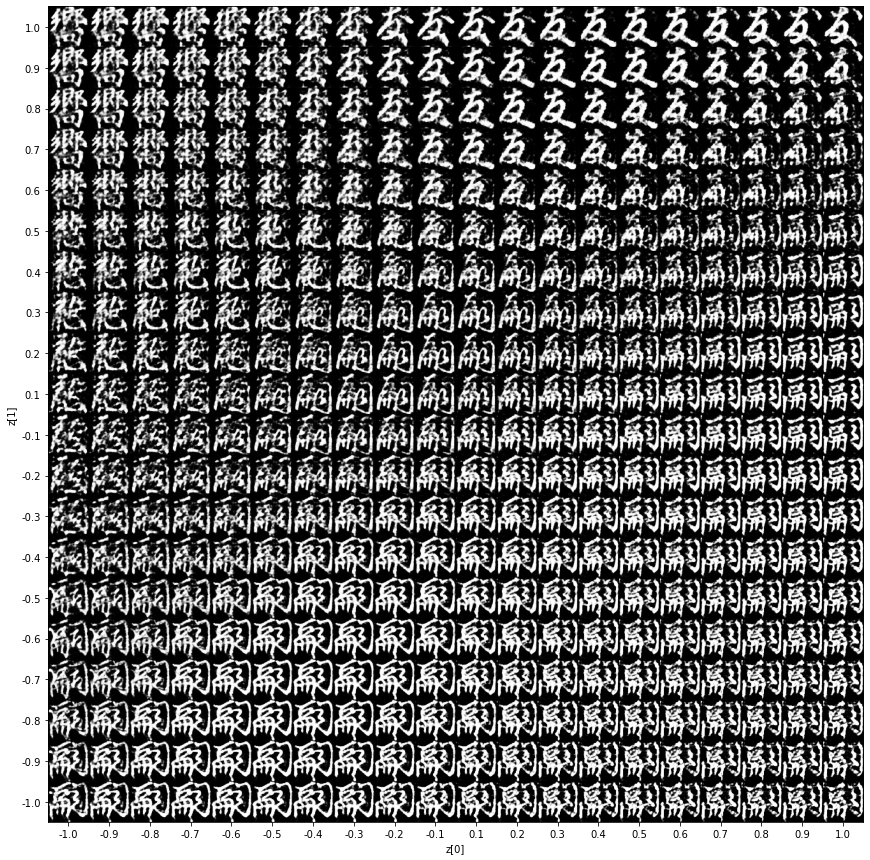

In [16]:
plot_latent_space(vae, n=20)

З отриманого латентного простору бачимо, що є дуже схожі  символи, що використовувалися при навчанні.

Додамо ще згорткових шарів і дослідимо як змінилася наша модель

In [19]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(124, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder1 = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder1")

encoder1.summary()

Model: "encoder1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 8, 8, 124)    71548       ['conv2d_4[0][0]']               
                                                                                           

In [24]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8* 8 * 124, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 124))(x)
x = layers.Conv2DTranspose(123, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder1 = keras.Model(latent_inputs, decoder_outputs, name="decoder1")

decoder1.summary()

Model: "decoder1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 7936)              23808     
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 124)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 16, 16, 123)      137391    
 ranspose)                                                       
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 32, 32, 64)       70912     
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 64, 64, 32)       184

In [25]:
vae1 = VAE(encoder1, decoder1)
vae1.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae1.fit(mnist_digits, epochs=1000, batch_size=32)

Epoch 1/1000
3/3 [==============================] - 1s 274ms/step - total_loss: 2828.7102 - reconstruction_loss: 2828.6875 - kl_loss: 0.0180
Epoch 2/1000
3/3 [==============================] - 1s 253ms/step - total_loss: 2746.6570 - reconstruction_loss: 2744.5212 - kl_loss: 1.7119
Epoch 3/1000
3/3 [==============================] - 1s 297ms/step - total_loss: 3133.3689 - reconstruction_loss: 2865.5476 - kl_loss: 294.2148
Epoch 4/1000
3/3 [==============================] - 1s 277ms/step - total_loss: 2601.5674 - reconstruction_loss: 2595.9111 - kl_loss: 6.2491
Epoch 5/1000
3/3 [==============================] - 1s 300ms/step - total_loss: 2639.1248 - reconstruction_loss: 2638.6848 - kl_loss: 0.4685
Epoch 6/1000
3/3 [==============================] - 1s 296ms/step - total_loss: 2618.7131 - reconstruction_loss: 2618.6094 - kl_loss: 0.1098
Epoch 7/1000
3/3 [==============================] - 1s 288ms/step - total_loss: 2571.1541 - reconstruction_loss: 2571.1145 - kl_loss: 0.0411
Epoch 8/100

3/3 [==============================] - 1s 295ms/step - total_loss: 1706.0488 - reconstruction_loss: 1695.4144 - kl_loss: 10.6973
Epoch 116/1000
3/3 [==============================] - 1s 249ms/step - total_loss: 1693.3622 - reconstruction_loss: 1682.4639 - kl_loss: 10.7667
Epoch 117/1000
3/3 [==============================] - 1s 265ms/step - total_loss: 1709.1578 - reconstruction_loss: 1699.2212 - kl_loss: 10.1596
Epoch 118/1000
3/3 [==============================] - 1s 226ms/step - total_loss: 1690.6051 - reconstruction_loss: 1679.4502 - kl_loss: 11.0605
Epoch 119/1000
3/3 [==============================] - 1s 255ms/step - total_loss: 1699.2386 - reconstruction_loss: 1688.6627 - kl_loss: 10.5625
Epoch 120/1000
3/3 [==============================] - 1s 243ms/step - total_loss: 1688.5679 - reconstruction_loss: 1677.7831 - kl_loss: 10.6076
Epoch 121/1000
3/3 [==============================] - 1s 286ms/step - total_loss: 1685.6255 - reconstruction_loss: 1674.2563 - kl_loss: 11.1803
Epoch 1

3/3 [==============================] - 1s 220ms/step - total_loss: 1592.5767 - reconstruction_loss: 1580.8149 - kl_loss: 11.9059
Epoch 173/1000
3/3 [==============================] - 1s 251ms/step - total_loss: 1583.6659 - reconstruction_loss: 1571.0924 - kl_loss: 12.4061
Epoch 174/1000
3/3 [==============================] - 1s 214ms/step - total_loss: 1588.4047 - reconstruction_loss: 1576.8026 - kl_loss: 11.6109
Epoch 175/1000
3/3 [==============================] - 1s 215ms/step - total_loss: 1577.8829 - reconstruction_loss: 1565.5645 - kl_loss: 12.0275
Epoch 176/1000
3/3 [==============================] - 1s 216ms/step - total_loss: 1588.7231 - reconstruction_loss: 1576.7915 - kl_loss: 12.2861
Epoch 177/1000
3/3 [==============================] - 1s 222ms/step - total_loss: 1565.3854 - reconstruction_loss: 1553.5939 - kl_loss: 11.8436
Epoch 178/1000
3/3 [==============================] - 1s 218ms/step - total_loss: 1574.1963 - reconstruction_loss: 1561.9565 - kl_loss: 12.0821
Epoch 1

Epoch 229/1000
3/3 [==============================] - 2s 531ms/step - total_loss: 1504.0684 - reconstruction_loss: 1491.6276 - kl_loss: 12.9207
Epoch 230/1000
3/3 [==============================] - 2s 541ms/step - total_loss: 1489.1456 - reconstruction_loss: 1475.5970 - kl_loss: 13.4423
Epoch 231/1000
3/3 [==============================] - 2s 523ms/step - total_loss: 1477.3422 - reconstruction_loss: 1463.9000 - kl_loss: 13.3128
Epoch 232/1000
3/3 [==============================] - 2s 583ms/step - total_loss: 1489.4702 - reconstruction_loss: 1476.4912 - kl_loss: 12.9258
Epoch 233/1000
3/3 [==============================] - 2s 561ms/step - total_loss: 1484.8444 - reconstruction_loss: 1471.5117 - kl_loss: 13.3942
Epoch 234/1000
3/3 [==============================] - 2s 562ms/step - total_loss: 1506.0210 - reconstruction_loss: 1492.8263 - kl_loss: 13.3225
Epoch 235/1000
3/3 [==============================] - 2s 534ms/step - total_loss: 1480.1740 - reconstruction_loss: 1466.9020 - kl_loss: 

Epoch 342/1000
3/3 [==============================] - 1s 270ms/step - total_loss: 1405.1676 - reconstruction_loss: 1392.0760 - kl_loss: 13.2189
Epoch 343/1000
3/3 [==============================] - 1s 261ms/step - total_loss: 1404.7054 - reconstruction_loss: 1390.7539 - kl_loss: 14.1084
Epoch 344/1000
3/3 [==============================] - 1s 260ms/step - total_loss: 1384.2465 - reconstruction_loss: 1370.7162 - kl_loss: 13.9313
Epoch 345/1000
3/3 [==============================] - 1s 269ms/step - total_loss: 1353.1630 - reconstruction_loss: 1338.2921 - kl_loss: 14.3202
Epoch 346/1000
3/3 [==============================] - 1s 287ms/step - total_loss: 1368.9038 - reconstruction_loss: 1355.0179 - kl_loss: 13.8304
Epoch 347/1000
3/3 [==============================] - 1s 301ms/step - total_loss: 1355.2939 - reconstruction_loss: 1341.3661 - kl_loss: 14.0233
Epoch 348/1000
3/3 [==============================] - 1s 227ms/step - total_loss: 1348.6406 - reconstruction_loss: 1334.8546 - kl_loss: 

Epoch 455/1000
3/3 [==============================] - 1s 206ms/step - total_loss: 1212.8815 - reconstruction_loss: 1197.3650 - kl_loss: 15.4305
Epoch 456/1000
3/3 [==============================] - 1s 210ms/step - total_loss: 1227.9452 - reconstruction_loss: 1212.5145 - kl_loss: 15.6069
Epoch 457/1000
3/3 [==============================] - 1s 204ms/step - total_loss: 1212.1415 - reconstruction_loss: 1196.6770 - kl_loss: 15.4515
Epoch 458/1000
3/3 [==============================] - 1s 202ms/step - total_loss: 1220.1837 - reconstruction_loss: 1204.7550 - kl_loss: 15.6818
Epoch 459/1000
3/3 [==============================] - 1s 225ms/step - total_loss: 1230.5402 - reconstruction_loss: 1214.7286 - kl_loss: 15.5050
Epoch 460/1000
3/3 [==============================] - 1s 222ms/step - total_loss: 1224.3002 - reconstruction_loss: 1208.2772 - kl_loss: 15.6582
Epoch 461/1000
3/3 [==============================] - 1s 223ms/step - total_loss: 1281.3663 - reconstruction_loss: 1266.0045 - kl_loss: 

Epoch 568/1000
3/3 [==============================] - 1s 291ms/step - total_loss: 1186.8595 - reconstruction_loss: 1170.4976 - kl_loss: 15.9423
Epoch 569/1000
3/3 [==============================] - 1s 246ms/step - total_loss: 1186.6715 - reconstruction_loss: 1170.5093 - kl_loss: 16.0157
Epoch 570/1000
3/3 [==============================] - 1s 208ms/step - total_loss: 1173.1516 - reconstruction_loss: 1157.0566 - kl_loss: 15.7265
Epoch 571/1000
3/3 [==============================] - 1s 264ms/step - total_loss: 1179.1108 - reconstruction_loss: 1162.9675 - kl_loss: 15.8987
Epoch 572/1000
3/3 [==============================] - 1s 266ms/step - total_loss: 1173.1960 - reconstruction_loss: 1157.1083 - kl_loss: 15.8710
Epoch 573/1000
3/3 [==============================] - 1s 244ms/step - total_loss: 1154.5961 - reconstruction_loss: 1138.2987 - kl_loss: 16.1156
Epoch 574/1000
3/3 [==============================] - 1s 239ms/step - total_loss: 1172.0927 - reconstruction_loss: 1156.4841 - kl_loss: 

Epoch 681/1000
3/3 [==============================] - 1s 220ms/step - total_loss: 1099.7208 - reconstruction_loss: 1083.7178 - kl_loss: 16.2347
Epoch 682/1000
3/3 [==============================] - 1s 221ms/step - total_loss: 1100.5864 - reconstruction_loss: 1084.3322 - kl_loss: 16.2007
Epoch 683/1000
3/3 [==============================] - 1s 274ms/step - total_loss: 1120.7412 - reconstruction_loss: 1104.5615 - kl_loss: 16.4081
Epoch 684/1000
3/3 [==============================] - 1s 290ms/step - total_loss: 1157.9166 - reconstruction_loss: 1141.8663 - kl_loss: 16.1939
Epoch 685/1000
3/3 [==============================] - 1s 262ms/step - total_loss: 1148.6637 - reconstruction_loss: 1132.2263 - kl_loss: 16.1228
Epoch 686/1000
3/3 [==============================] - 1s 215ms/step - total_loss: 1143.2758 - reconstruction_loss: 1127.0610 - kl_loss: 16.3162
Epoch 687/1000
3/3 [==============================] - 1s 225ms/step - total_loss: 1157.5747 - reconstruction_loss: 1141.3013 - kl_loss: 

3/3 [==============================] - 1s 227ms/step - total_loss: 996.2161 - reconstruction_loss: 979.3206 - kl_loss: 16.7483
Epoch 795/1000
3/3 [==============================] - 1s 215ms/step - total_loss: 1000.7512 - reconstruction_loss: 984.0906 - kl_loss: 16.6756
Epoch 796/1000
3/3 [==============================] - 1s 227ms/step - total_loss: 995.5171 - reconstruction_loss: 978.4966 - kl_loss: 16.7100
Epoch 797/1000
3/3 [==============================] - 1s 231ms/step - total_loss: 987.4634 - reconstruction_loss: 970.9839 - kl_loss: 16.6660
Epoch 798/1000
3/3 [==============================] - 1s 221ms/step - total_loss: 986.2735 - reconstruction_loss: 969.5032 - kl_loss: 16.6975
Epoch 799/1000
3/3 [==============================] - 1s 229ms/step - total_loss: 989.3715 - reconstruction_loss: 972.6399 - kl_loss: 16.7488
Epoch 800/1000
3/3 [==============================] - 1s 230ms/step - total_loss: 1017.4666 - reconstruction_loss: 1000.7014 - kl_loss: 16.6970
Epoch 801/1000
3/3

3/3 [==============================] - 1s 241ms/step - total_loss: 951.0776 - reconstruction_loss: 934.5792 - kl_loss: 16.7788
Epoch 909/1000
3/3 [==============================] - 1s 265ms/step - total_loss: 965.4039 - reconstruction_loss: 948.1981 - kl_loss: 16.7688
Epoch 910/1000
3/3 [==============================] - 1s 221ms/step - total_loss: 976.6535 - reconstruction_loss: 959.8487 - kl_loss: 16.7338
Epoch 911/1000
3/3 [==============================] - 1s 254ms/step - total_loss: 993.5552 - reconstruction_loss: 976.8224 - kl_loss: 16.7947
Epoch 912/1000
3/3 [==============================] - 1s 224ms/step - total_loss: 982.1477 - reconstruction_loss: 965.4233 - kl_loss: 16.8209
Epoch 913/1000
3/3 [==============================] - 1s 224ms/step - total_loss: 1009.6273 - reconstruction_loss: 993.0097 - kl_loss: 16.7150
Epoch 914/1000
3/3 [==============================] - 1s 218ms/step - total_loss: 997.4619 - reconstruction_loss: 980.6730 - kl_loss: 16.7118
Epoch 915/1000
3/3 [

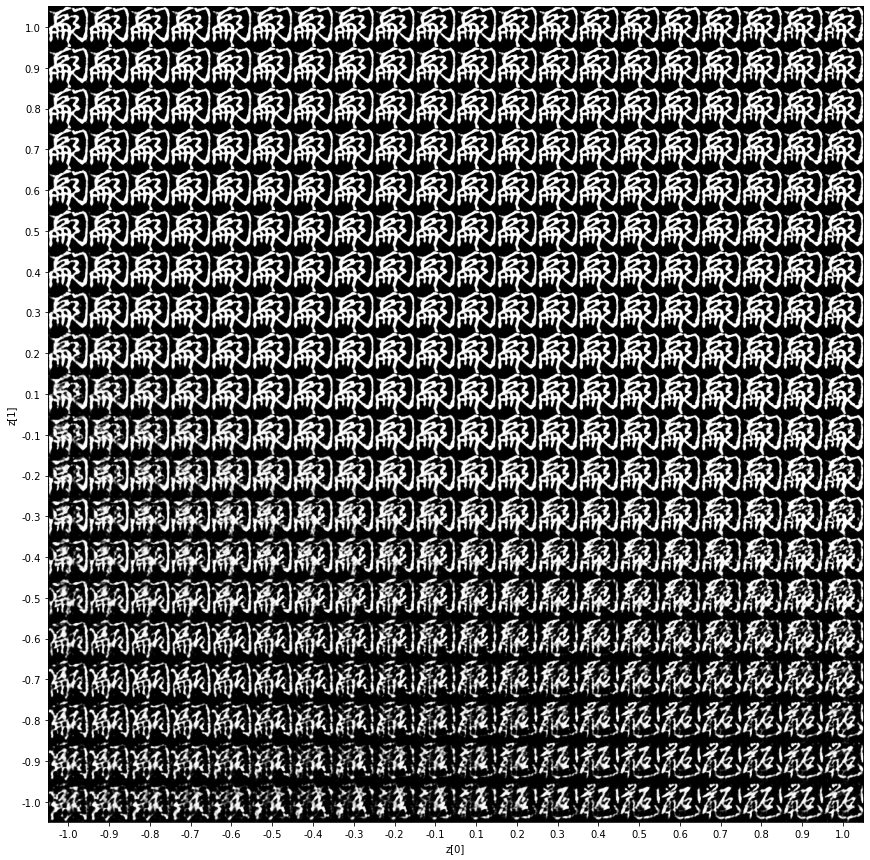

In [26]:
plot_latent_space(vae1, n=20)

Бачимо що латентний простір має переважаючий один символ

In [30]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Flatten()(x)
x = layers.Dense(16)(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder2 = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder2")

encoder2.summary()

Model: "encoder2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 32)   320         ['input_9[0][0]']                
                                                                                                  
 flatten_4 (Flatten)            (None, 32768)        0           ['conv2d_11[0][0]']              
                                                                                                  
 dense_8 (Dense)                (None, 16)           524304      ['flatten_4[0][0]']              
                                                                                           

In [31]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32*32*32, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 32))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder2 = keras.Model(latent_inputs, decoder_outputs, name="decoder2")

In [34]:
vae2 = VAE(encoder2, decoder2)
vae2.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae2.fit(mnist_digits, epochs=3000, batch_size=32)

Epoch 1/3000
3/3 [==============================] - 0s 137ms/step - total_loss: 1139.5211 - reconstruction_loss: 1127.0853 - kl_loss: 12.1020
Epoch 2/3000
3/3 [==============================] - 1s 160ms/step - total_loss: 1159.0802 - reconstruction_loss: 1146.5039 - kl_loss: 12.7363
Epoch 3/3000
3/3 [==============================] - 0s 152ms/step - total_loss: 1101.1558 - reconstruction_loss: 1089.8385 - kl_loss: 11.3970
Epoch 4/3000
3/3 [==============================] - 1s 193ms/step - total_loss: 1073.5270 - reconstruction_loss: 1061.2452 - kl_loss: 11.9416
Epoch 5/3000
3/3 [==============================] - 1s 199ms/step - total_loss: 1053.2822 - reconstruction_loss: 1041.4777 - kl_loss: 11.9006
Epoch 6/3000
3/3 [==============================] - 1s 156ms/step - total_loss: 1035.6178 - reconstruction_loss: 1024.2266 - kl_loss: 11.7197
Epoch 7/3000
3/3 [==============================] - 0s 152ms/step - total_loss: 1024.1788 - reconstruction_loss: 1012.2637 - kl_loss: 11.5573
Epoch 

3/3 [==============================] - 1s 151ms/step - total_loss: 984.7620 - reconstruction_loss: 971.7840 - kl_loss: 12.7948
Epoch 117/3000
3/3 [==============================] - 1s 172ms/step - total_loss: 993.0730 - reconstruction_loss: 980.3489 - kl_loss: 12.8776
Epoch 118/3000
3/3 [==============================] - 1s 160ms/step - total_loss: 989.6968 - reconstruction_loss: 977.1428 - kl_loss: 12.5894
Epoch 119/3000
3/3 [==============================] - 1s 176ms/step - total_loss: 993.1419 - reconstruction_loss: 980.2200 - kl_loss: 13.0785
Epoch 120/3000
3/3 [==============================] - 1s 170ms/step - total_loss: 987.9352 - reconstruction_loss: 975.6055 - kl_loss: 12.3112
Epoch 121/3000
3/3 [==============================] - 1s 222ms/step - total_loss: 992.5662 - reconstruction_loss: 979.5969 - kl_loss: 12.8938
Epoch 122/3000
3/3 [==============================] - 1s 171ms/step - total_loss: 985.0474 - reconstruction_loss: 972.4681 - kl_loss: 12.4552
Epoch 123/3000
3/3 [=

3/3 [==============================] - 1s 179ms/step - total_loss: 964.1600 - reconstruction_loss: 950.9406 - kl_loss: 12.6508
Epoch 231/3000
3/3 [==============================] - 1s 165ms/step - total_loss: 969.4014 - reconstruction_loss: 956.9592 - kl_loss: 12.4903
Epoch 232/3000
3/3 [==============================] - 1s 161ms/step - total_loss: 972.0962 - reconstruction_loss: 959.4568 - kl_loss: 12.7637
Epoch 233/3000
3/3 [==============================] - 1s 163ms/step - total_loss: 971.5392 - reconstruction_loss: 959.2246 - kl_loss: 12.3808
Epoch 234/3000
3/3 [==============================] - 1s 168ms/step - total_loss: 965.8615 - reconstruction_loss: 953.3176 - kl_loss: 12.6638
Epoch 235/3000
3/3 [==============================] - 1s 169ms/step - total_loss: 970.3793 - reconstruction_loss: 958.1208 - kl_loss: 12.4279
Epoch 236/3000
3/3 [==============================] - 1s 155ms/step - total_loss: 970.1494 - reconstruction_loss: 957.3486 - kl_loss: 12.6548
Epoch 237/3000
3/3 [=

3/3 [==============================] - 1s 166ms/step - total_loss: 946.6547 - reconstruction_loss: 934.0969 - kl_loss: 12.7355
Epoch 345/3000
3/3 [==============================] - 1s 164ms/step - total_loss: 943.8397 - reconstruction_loss: 931.2221 - kl_loss: 12.3606
Epoch 346/3000
3/3 [==============================] - 1s 177ms/step - total_loss: 944.6876 - reconstruction_loss: 931.9336 - kl_loss: 12.7747
Epoch 347/3000
3/3 [==============================] - 1s 167ms/step - total_loss: 960.4866 - reconstruction_loss: 948.4126 - kl_loss: 12.3040
Epoch 348/3000
3/3 [==============================] - 1s 163ms/step - total_loss: 950.4355 - reconstruction_loss: 937.8577 - kl_loss: 12.6261
Epoch 349/3000
3/3 [==============================] - 0s 157ms/step - total_loss: 951.6118 - reconstruction_loss: 939.2292 - kl_loss: 12.4651
Epoch 350/3000
3/3 [==============================] - 1s 186ms/step - total_loss: 954.1420 - reconstruction_loss: 941.5550 - kl_loss: 12.4851
Epoch 351/3000
3/3 [=

3/3 [==============================] - 1s 166ms/step - total_loss: 940.6072 - reconstruction_loss: 928.6141 - kl_loss: 11.9599
Epoch 459/3000
3/3 [==============================] - 1s 168ms/step - total_loss: 930.0615 - reconstruction_loss: 918.3006 - kl_loss: 12.1725
Epoch 460/3000
3/3 [==============================] - 0s 151ms/step - total_loss: 937.4375 - reconstruction_loss: 925.5044 - kl_loss: 12.0705
Epoch 461/3000
3/3 [==============================] - 1s 167ms/step - total_loss: 931.3335 - reconstruction_loss: 919.5603 - kl_loss: 12.0226
Epoch 462/3000
3/3 [==============================] - 1s 169ms/step - total_loss: 943.8825 - reconstruction_loss: 931.6575 - kl_loss: 12.1204
Epoch 463/3000
3/3 [==============================] - 1s 164ms/step - total_loss: 945.8853 - reconstruction_loss: 933.7955 - kl_loss: 12.1146
Epoch 464/3000
3/3 [==============================] - 1s 179ms/step - total_loss: 946.1895 - reconstruction_loss: 934.2849 - kl_loss: 12.0416
Epoch 465/3000
3/3 [=

3/3 [==============================] - 0s 153ms/step - total_loss: 933.0145 - reconstruction_loss: 921.0369 - kl_loss: 11.9177
Epoch 573/3000
3/3 [==============================] - 1s 154ms/step - total_loss: 925.0181 - reconstruction_loss: 913.3703 - kl_loss: 12.0821
Epoch 574/3000
3/3 [==============================] - 1s 186ms/step - total_loss: 932.9175 - reconstruction_loss: 921.0446 - kl_loss: 12.0608
Epoch 575/3000
3/3 [==============================] - 1s 173ms/step - total_loss: 929.8198 - reconstruction_loss: 917.9509 - kl_loss: 12.0747
Epoch 576/3000
3/3 [==============================] - 1s 166ms/step - total_loss: 921.1047 - reconstruction_loss: 909.0862 - kl_loss: 12.0161
Epoch 577/3000
3/3 [==============================] - 1s 165ms/step - total_loss: 922.8360 - reconstruction_loss: 910.6760 - kl_loss: 12.0630
Epoch 578/3000
3/3 [==============================] - 1s 168ms/step - total_loss: 919.4188 - reconstruction_loss: 907.2957 - kl_loss: 12.0935
Epoch 579/3000
3/3 [=

3/3 [==============================] - 0s 160ms/step - total_loss: 917.3616 - reconstruction_loss: 905.4977 - kl_loss: 11.8486
Epoch 687/3000
3/3 [==============================] - 1s 176ms/step - total_loss: 921.1431 - reconstruction_loss: 909.0580 - kl_loss: 12.0211
Epoch 688/3000
3/3 [==============================] - 1s 164ms/step - total_loss: 917.4929 - reconstruction_loss: 905.6626 - kl_loss: 11.8259
Epoch 689/3000
3/3 [==============================] - 1s 166ms/step - total_loss: 907.0119 - reconstruction_loss: 894.8469 - kl_loss: 11.9522
Epoch 690/3000
3/3 [==============================] - 1s 168ms/step - total_loss: 903.8023 - reconstruction_loss: 891.7581 - kl_loss: 11.9089
Epoch 691/3000
3/3 [==============================] - 1s 161ms/step - total_loss: 908.1778 - reconstruction_loss: 896.3361 - kl_loss: 11.9464
Epoch 692/3000
3/3 [==============================] - 1s 168ms/step - total_loss: 912.9897 - reconstruction_loss: 900.8815 - kl_loss: 11.8453
Epoch 693/3000
3/3 [=

3/3 [==============================] - 1s 175ms/step - total_loss: 901.6317 - reconstruction_loss: 889.8836 - kl_loss: 12.0213
Epoch 801/3000
3/3 [==============================] - 1s 191ms/step - total_loss: 902.0827 - reconstruction_loss: 890.5095 - kl_loss: 11.7332
Epoch 802/3000
3/3 [==============================] - 1s 190ms/step - total_loss: 907.4702 - reconstruction_loss: 895.4897 - kl_loss: 11.9827
Epoch 803/3000
3/3 [==============================] - 1s 188ms/step - total_loss: 906.3683 - reconstruction_loss: 894.7287 - kl_loss: 11.7323
Epoch 804/3000
3/3 [==============================] - 1s 172ms/step - total_loss: 919.4201 - reconstruction_loss: 907.4962 - kl_loss: 12.0249
Epoch 805/3000
3/3 [==============================] - 1s 256ms/step - total_loss: 909.3445 - reconstruction_loss: 897.8391 - kl_loss: 11.6583
Epoch 806/3000
3/3 [==============================] - 1s 207ms/step - total_loss: 896.6563 - reconstruction_loss: 884.3592 - kl_loss: 12.0440
Epoch 807/3000
3/3 [=

3/3 [==============================] - 1s 195ms/step - total_loss: 904.8690 - reconstruction_loss: 893.0898 - kl_loss: 11.7157
Epoch 915/3000
3/3 [==============================] - 1s 193ms/step - total_loss: 901.4875 - reconstruction_loss: 890.0110 - kl_loss: 11.4304
Epoch 916/3000
3/3 [==============================] - 1s 208ms/step - total_loss: 903.2756 - reconstruction_loss: 891.5220 - kl_loss: 11.6192
Epoch 917/3000
3/3 [==============================] - 1s 214ms/step - total_loss: 906.7598 - reconstruction_loss: 895.6846 - kl_loss: 11.3483
Epoch 918/3000
3/3 [==============================] - 1s 277ms/step - total_loss: 898.4122 - reconstruction_loss: 887.1186 - kl_loss: 11.6184
Epoch 919/3000
3/3 [==============================] - 1s 225ms/step - total_loss: 901.9710 - reconstruction_loss: 890.1994 - kl_loss: 11.4228
Epoch 920/3000
3/3 [==============================] - 1s 240ms/step - total_loss: 906.2490 - reconstruction_loss: 894.6884 - kl_loss: 11.5773
Epoch 921/3000
3/3 [=

3/3 [==============================] - 1s 189ms/step - total_loss: 885.2949 - reconstruction_loss: 873.6619 - kl_loss: 11.4890
Epoch 1029/3000
3/3 [==============================] - 1s 196ms/step - total_loss: 892.7470 - reconstruction_loss: 881.4822 - kl_loss: 11.4165
Epoch 1030/3000
3/3 [==============================] - 1s 192ms/step - total_loss: 895.6609 - reconstruction_loss: 884.0646 - kl_loss: 11.6272
Epoch 1031/3000
3/3 [==============================] - 1s 185ms/step - total_loss: 892.2771 - reconstruction_loss: 880.7231 - kl_loss: 11.5082
Epoch 1032/3000
3/3 [==============================] - 1s 185ms/step - total_loss: 895.1412 - reconstruction_loss: 883.7930 - kl_loss: 11.4978
Epoch 1033/3000
3/3 [==============================] - 1s 189ms/step - total_loss: 890.0635 - reconstruction_loss: 878.7507 - kl_loss: 11.5348
Epoch 1034/3000
3/3 [==============================] - 1s 191ms/step - total_loss: 893.9886 - reconstruction_loss: 882.9103 - kl_loss: 11.4150
Epoch 1035/3000

3/3 [==============================] - 1s 187ms/step - total_loss: 889.1447 - reconstruction_loss: 877.7552 - kl_loss: 11.3508
Epoch 1143/3000
3/3 [==============================] - 1s 188ms/step - total_loss: 889.2112 - reconstruction_loss: 877.8006 - kl_loss: 11.3019
Epoch 1144/3000
3/3 [==============================] - 1s 186ms/step - total_loss: 882.7391 - reconstruction_loss: 871.5666 - kl_loss: 11.4253
Epoch 1145/3000
3/3 [==============================] - 1s 187ms/step - total_loss: 887.6133 - reconstruction_loss: 876.5516 - kl_loss: 11.2811
Epoch 1146/3000
3/3 [==============================] - 1s 193ms/step - total_loss: 890.9930 - reconstruction_loss: 879.4480 - kl_loss: 11.4844
Epoch 1147/3000
3/3 [==============================] - 1s 190ms/step - total_loss: 880.1486 - reconstruction_loss: 868.9437 - kl_loss: 11.1738
Epoch 1148/3000
3/3 [==============================] - 1s 210ms/step - total_loss: 880.3279 - reconstruction_loss: 869.1025 - kl_loss: 11.4957
Epoch 1149/3000

3/3 [==============================] - 1s 217ms/step - total_loss: 877.9733 - reconstruction_loss: 866.6522 - kl_loss: 11.1304
Epoch 1257/3000
3/3 [==============================] - 1s 223ms/step - total_loss: 874.6878 - reconstruction_loss: 863.4586 - kl_loss: 11.3041
Epoch 1258/3000
3/3 [==============================] - 1s 245ms/step - total_loss: 877.2784 - reconstruction_loss: 866.2682 - kl_loss: 11.1041
Epoch 1259/3000
3/3 [==============================] - 1s 189ms/step - total_loss: 889.0120 - reconstruction_loss: 877.5408 - kl_loss: 11.2944
Epoch 1260/3000
3/3 [==============================] - 1s 189ms/step - total_loss: 882.2307 - reconstruction_loss: 871.0146 - kl_loss: 11.1143
Epoch 1261/3000
3/3 [==============================] - 1s 174ms/step - total_loss: 868.9670 - reconstruction_loss: 857.4495 - kl_loss: 11.2935
Epoch 1262/3000
3/3 [==============================] - 1s 194ms/step - total_loss: 874.2151 - reconstruction_loss: 863.3718 - kl_loss: 11.1613
Epoch 1263/3000

3/3 [==============================] - 1s 214ms/step - total_loss: 880.2310 - reconstruction_loss: 869.1851 - kl_loss: 11.3145
Epoch 1371/3000
3/3 [==============================] - 1s 206ms/step - total_loss: 863.0376 - reconstruction_loss: 852.0467 - kl_loss: 11.0105
Epoch 1372/3000
3/3 [==============================] - 1s 196ms/step - total_loss: 860.9000 - reconstruction_loss: 849.4363 - kl_loss: 11.2362
Epoch 1373/3000
3/3 [==============================] - 1s 197ms/step - total_loss: 859.0274 - reconstruction_loss: 847.8874 - kl_loss: 11.0780
Epoch 1374/3000
3/3 [==============================] - 1s 236ms/step - total_loss: 864.0791 - reconstruction_loss: 853.1453 - kl_loss: 11.2191
Epoch 1375/3000
3/3 [==============================] - 1s 207ms/step - total_loss: 875.3791 - reconstruction_loss: 864.3801 - kl_loss: 11.1313
Epoch 1376/3000
3/3 [==============================] - 1s 206ms/step - total_loss: 865.7422 - reconstruction_loss: 854.5682 - kl_loss: 11.1988
Epoch 1377/3000

3/3 [==============================] - 1s 191ms/step - total_loss: 853.6916 - reconstruction_loss: 842.4985 - kl_loss: 11.2100
Epoch 1485/3000
3/3 [==============================] - 1s 190ms/step - total_loss: 868.2404 - reconstruction_loss: 856.9854 - kl_loss: 11.1621
Epoch 1486/3000
3/3 [==============================] - 1s 195ms/step - total_loss: 861.8200 - reconstruction_loss: 850.6838 - kl_loss: 11.1224
Epoch 1487/3000
3/3 [==============================] - 1s 214ms/step - total_loss: 847.3205 - reconstruction_loss: 835.9318 - kl_loss: 11.1668
Epoch 1488/3000
3/3 [==============================] - 1s 194ms/step - total_loss: 859.3002 - reconstruction_loss: 847.9647 - kl_loss: 11.1657
Epoch 1489/3000
3/3 [==============================] - 1s 191ms/step - total_loss: 857.9424 - reconstruction_loss: 846.8084 - kl_loss: 11.1423
Epoch 1490/3000
3/3 [==============================] - 1s 195ms/step - total_loss: 862.7106 - reconstruction_loss: 851.0953 - kl_loss: 11.1661
Epoch 1491/3000

3/3 [==============================] - 1s 199ms/step - total_loss: 868.3026 - reconstruction_loss: 857.5746 - kl_loss: 10.8049
Epoch 1599/3000
3/3 [==============================] - 1s 191ms/step - total_loss: 869.4175 - reconstruction_loss: 858.7215 - kl_loss: 10.9818
Epoch 1600/3000
3/3 [==============================] - 1s 174ms/step - total_loss: 863.2650 - reconstruction_loss: 852.4190 - kl_loss: 10.9345
Epoch 1601/3000
3/3 [==============================] - 1s 201ms/step - total_loss: 850.9190 - reconstruction_loss: 839.7053 - kl_loss: 10.9183
Epoch 1602/3000
3/3 [==============================] - 1s 192ms/step - total_loss: 859.1838 - reconstruction_loss: 848.3157 - kl_loss: 10.9147
Epoch 1603/3000
3/3 [==============================] - 1s 181ms/step - total_loss: 865.1076 - reconstruction_loss: 854.1673 - kl_loss: 10.8469
Epoch 1604/3000
3/3 [==============================] - 1s 177ms/step - total_loss: 855.2878 - reconstruction_loss: 844.2949 - kl_loss: 10.9967
Epoch 1605/3000

3/3 [==============================] - 1s 161ms/step - total_loss: 860.7825 - reconstruction_loss: 850.1965 - kl_loss: 10.9304
Epoch 1713/3000
3/3 [==============================] - 1s 169ms/step - total_loss: 857.8065 - reconstruction_loss: 846.9025 - kl_loss: 10.9234
Epoch 1714/3000
3/3 [==============================] - 1s 165ms/step - total_loss: 871.7708 - reconstruction_loss: 860.7625 - kl_loss: 10.9163
Epoch 1715/3000
3/3 [==============================] - 1s 168ms/step - total_loss: 856.1351 - reconstruction_loss: 845.2119 - kl_loss: 10.8645
Epoch 1716/3000
3/3 [==============================] - 1s 164ms/step - total_loss: 860.9324 - reconstruction_loss: 849.9153 - kl_loss: 10.9689
Epoch 1717/3000
3/3 [==============================] - 1s 169ms/step - total_loss: 850.5288 - reconstruction_loss: 839.5939 - kl_loss: 10.9181
Epoch 1718/3000
3/3 [==============================] - 1s 166ms/step - total_loss: 864.7227 - reconstruction_loss: 853.8019 - kl_loss: 10.9469
Epoch 1719/3000

3/3 [==============================] - 1s 229ms/step - total_loss: 853.2324 - reconstruction_loss: 842.5649 - kl_loss: 10.7192
Epoch 1827/3000
3/3 [==============================] - 1s 189ms/step - total_loss: 857.1267 - reconstruction_loss: 846.8035 - kl_loss: 10.6388
Epoch 1828/3000
3/3 [==============================] - 1s 218ms/step - total_loss: 853.7581 - reconstruction_loss: 843.1638 - kl_loss: 10.7512
Epoch 1829/3000
3/3 [==============================] - 1s 197ms/step - total_loss: 853.0062 - reconstruction_loss: 842.5601 - kl_loss: 10.6889
Epoch 1830/3000
3/3 [==============================] - 1s 235ms/step - total_loss: 853.0247 - reconstruction_loss: 842.3000 - kl_loss: 10.7170
Epoch 1831/3000
3/3 [==============================] - 1s 243ms/step - total_loss: 837.5901 - reconstruction_loss: 826.6109 - kl_loss: 10.7669
Epoch 1832/3000
3/3 [==============================] - 1s 177ms/step - total_loss: 846.9771 - reconstruction_loss: 836.3184 - kl_loss: 10.6614
Epoch 1833/3000

3/3 [==============================] - 1s 171ms/step - total_loss: 851.7748 - reconstruction_loss: 841.2631 - kl_loss: 10.4790
Epoch 1941/3000
3/3 [==============================] - 1s 172ms/step - total_loss: 837.7747 - reconstruction_loss: 826.7969 - kl_loss: 10.9790
Epoch 1942/3000
3/3 [==============================] - 1s 163ms/step - total_loss: 845.3813 - reconstruction_loss: 834.7917 - kl_loss: 10.5403
Epoch 1943/3000
3/3 [==============================] - 1s 164ms/step - total_loss: 853.3755 - reconstruction_loss: 842.6432 - kl_loss: 10.7931
Epoch 1944/3000
3/3 [==============================] - 1s 165ms/step - total_loss: 845.4913 - reconstruction_loss: 834.6706 - kl_loss: 10.6103
Epoch 1945/3000
3/3 [==============================] - 1s 158ms/step - total_loss: 839.6838 - reconstruction_loss: 828.7719 - kl_loss: 10.7987
Epoch 1946/3000
3/3 [==============================] - 1s 150ms/step - total_loss: 849.0122 - reconstruction_loss: 838.6226 - kl_loss: 10.6353
Epoch 1947/3000

3/3 [==============================] - 1s 160ms/step - total_loss: 846.0068 - reconstruction_loss: 835.1961 - kl_loss: 10.6145
Epoch 2055/3000
3/3 [==============================] - 1s 162ms/step - total_loss: 850.1858 - reconstruction_loss: 839.7692 - kl_loss: 10.4901
Epoch 2056/3000
3/3 [==============================] - 1s 163ms/step - total_loss: 844.3055 - reconstruction_loss: 833.5796 - kl_loss: 10.6487
Epoch 2057/3000
3/3 [==============================] - 1s 170ms/step - total_loss: 843.7133 - reconstruction_loss: 833.1603 - kl_loss: 10.3964
Epoch 2058/3000
3/3 [==============================] - 1s 163ms/step - total_loss: 846.4634 - reconstruction_loss: 835.8894 - kl_loss: 10.6956
Epoch 2059/3000
3/3 [==============================] - 1s 164ms/step - total_loss: 856.5672 - reconstruction_loss: 846.2583 - kl_loss: 10.4158
Epoch 2060/3000
3/3 [==============================] - 1s 168ms/step - total_loss: 843.7996 - reconstruction_loss: 833.0708 - kl_loss: 10.6481
Epoch 2061/3000

3/3 [==============================] - 1s 168ms/step - total_loss: 846.9582 - reconstruction_loss: 836.3511 - kl_loss: 10.6119
Epoch 2169/3000
3/3 [==============================] - 1s 162ms/step - total_loss: 841.5998 - reconstruction_loss: 831.2360 - kl_loss: 10.3235
Epoch 2170/3000
3/3 [==============================] - 1s 167ms/step - total_loss: 844.0261 - reconstruction_loss: 833.3807 - kl_loss: 10.5694
Epoch 2171/3000
3/3 [==============================] - 1s 164ms/step - total_loss: 840.2065 - reconstruction_loss: 829.3457 - kl_loss: 10.4900
Epoch 2172/3000
3/3 [==============================] - 1s 162ms/step - total_loss: 849.0654 - reconstruction_loss: 838.7114 - kl_loss: 10.4735
Epoch 2173/3000
3/3 [==============================] - 1s 165ms/step - total_loss: 849.3901 - reconstruction_loss: 839.3743 - kl_loss: 10.3692
Epoch 2174/3000
3/3 [==============================] - 1s 164ms/step - total_loss: 855.1668 - reconstruction_loss: 844.6276 - kl_loss: 10.5247
Epoch 2175/3000

3/3 [==============================] - 1s 197ms/step - total_loss: 837.9411 - reconstruction_loss: 827.6990 - kl_loss: 10.2900
Epoch 2283/3000
3/3 [==============================] - 1s 159ms/step - total_loss: 829.4554 - reconstruction_loss: 819.0332 - kl_loss: 10.3200
Epoch 2284/3000
3/3 [==============================] - 1s 169ms/step - total_loss: 820.9166 - reconstruction_loss: 810.8514 - kl_loss: 10.2450
Epoch 2285/3000
3/3 [==============================] - 1s 174ms/step - total_loss: 832.0806 - reconstruction_loss: 821.5356 - kl_loss: 10.4057
Epoch 2286/3000
3/3 [==============================] - 1s 174ms/step - total_loss: 836.9333 - reconstruction_loss: 826.8496 - kl_loss: 10.1488
Epoch 2287/3000
3/3 [==============================] - 1s 166ms/step - total_loss: 837.5301 - reconstruction_loss: 826.8954 - kl_loss: 10.3688
Epoch 2288/3000
3/3 [==============================] - 1s 164ms/step - total_loss: 835.4712 - reconstruction_loss: 825.2028 - kl_loss: 10.2561
Epoch 2289/3000

3/3 [==============================] - 1s 159ms/step - total_loss: 834.4211 - reconstruction_loss: 824.1445 - kl_loss: 10.2537
Epoch 2397/3000
3/3 [==============================] - 1s 164ms/step - total_loss: 833.9521 - reconstruction_loss: 823.3403 - kl_loss: 10.4649
Epoch 2398/3000
3/3 [==============================] - 1s 156ms/step - total_loss: 829.5154 - reconstruction_loss: 819.1025 - kl_loss: 10.2566
Epoch 2399/3000
3/3 [==============================] - 1s 166ms/step - total_loss: 825.3394 - reconstruction_loss: 814.9104 - kl_loss: 10.4828
Epoch 2400/3000
3/3 [==============================] - 1s 165ms/step - total_loss: 837.4020 - reconstruction_loss: 827.1897 - kl_loss: 10.3467
Epoch 2401/3000
3/3 [==============================] - 1s 165ms/step - total_loss: 827.3391 - reconstruction_loss: 816.7646 - kl_loss: 10.4119
Epoch 2402/3000
3/3 [==============================] - 1s 159ms/step - total_loss: 829.8071 - reconstruction_loss: 819.3467 - kl_loss: 10.3242
Epoch 2403/3000

3/3 [==============================] - 1s 160ms/step - total_loss: 826.2697 - reconstruction_loss: 815.9141 - kl_loss: 10.3158
Epoch 2511/3000
3/3 [==============================] - 1s 170ms/step - total_loss: 828.3227 - reconstruction_loss: 817.8965 - kl_loss: 10.2643
Epoch 2512/3000
3/3 [==============================] - 1s 162ms/step - total_loss: 832.5362 - reconstruction_loss: 822.0103 - kl_loss: 10.3217
Epoch 2513/3000
3/3 [==============================] - 1s 166ms/step - total_loss: 818.3267 - reconstruction_loss: 808.1541 - kl_loss: 10.2798
Epoch 2514/3000
3/3 [==============================] - 1s 159ms/step - total_loss: 822.8635 - reconstruction_loss: 812.2734 - kl_loss: 10.2936
Epoch 2515/3000
3/3 [==============================] - 1s 169ms/step - total_loss: 824.6619 - reconstruction_loss: 814.3540 - kl_loss: 10.3162
Epoch 2516/3000
3/3 [==============================] - 1s 166ms/step - total_loss: 830.5374 - reconstruction_loss: 820.3237 - kl_loss: 10.2247
Epoch 2517/3000

3/3 [==============================] - 1s 165ms/step - total_loss: 826.9321 - reconstruction_loss: 816.7803 - kl_loss: 10.3340
Epoch 2625/3000
3/3 [==============================] - 0s 157ms/step - total_loss: 829.2303 - reconstruction_loss: 819.4961 - kl_loss: 10.0176
Epoch 2626/3000
3/3 [==============================] - 1s 165ms/step - total_loss: 830.2429 - reconstruction_loss: 820.0515 - kl_loss: 10.2766
Epoch 2627/3000
3/3 [==============================] - 1s 178ms/step - total_loss: 824.9106 - reconstruction_loss: 814.9168 - kl_loss: 10.0007
Epoch 2628/3000
3/3 [==============================] - 1s 168ms/step - total_loss: 823.6041 - reconstruction_loss: 813.4385 - kl_loss: 10.2467
Epoch 2629/3000
3/3 [==============================] - 1s 152ms/step - total_loss: 824.9600 - reconstruction_loss: 815.1536 - kl_loss: 10.0098
Epoch 2630/3000
3/3 [==============================] - 1s 168ms/step - total_loss: 825.4653 - reconstruction_loss: 815.1199 - kl_loss: 10.3532
Epoch 2631/3000

3/3 [==============================] - 1s 174ms/step - total_loss: 809.8414 - reconstruction_loss: 799.2267 - kl_loss: 10.2788
Epoch 2739/3000
3/3 [==============================] - 1s 169ms/step - total_loss: 815.4260 - reconstruction_loss: 805.0234 - kl_loss: 10.2235
Epoch 2740/3000
3/3 [==============================] - 1s 176ms/step - total_loss: 815.9321 - reconstruction_loss: 805.7493 - kl_loss: 10.2743
Epoch 2741/3000
3/3 [==============================] - 1s 172ms/step - total_loss: 809.5664 - reconstruction_loss: 799.2766 - kl_loss: 10.2766
Epoch 2742/3000
3/3 [==============================] - 1s 167ms/step - total_loss: 812.0782 - reconstruction_loss: 801.8887 - kl_loss: 10.1792
Epoch 2743/3000
3/3 [==============================] - 1s 167ms/step - total_loss: 818.4924 - reconstruction_loss: 808.2698 - kl_loss: 10.3512
Epoch 2744/3000
3/3 [==============================] - 1s 167ms/step - total_loss: 825.7024 - reconstruction_loss: 815.2357 - kl_loss: 10.1449
Epoch 2745/3000

3/3 [==============================] - 1s 185ms/step - total_loss: 829.4368 - reconstruction_loss: 819.3244 - kl_loss: 10.0733
Epoch 2853/3000
3/3 [==============================] - 1s 191ms/step - total_loss: 829.0540 - reconstruction_loss: 818.9605 - kl_loss: 9.9800
Epoch 2854/3000
3/3 [==============================] - 1s 194ms/step - total_loss: 828.0146 - reconstruction_loss: 817.9960 - kl_loss: 10.0131
Epoch 2855/3000
3/3 [==============================] - 1s 178ms/step - total_loss: 818.1660 - reconstruction_loss: 808.1816 - kl_loss: 9.9771
Epoch 2856/3000
3/3 [==============================] - 1s 175ms/step - total_loss: 828.1934 - reconstruction_loss: 818.2370 - kl_loss: 9.9672
Epoch 2857/3000
3/3 [==============================] - 1s 181ms/step - total_loss: 829.5276 - reconstruction_loss: 819.4265 - kl_loss: 9.9967
Epoch 2858/3000
3/3 [==============================] - 1s 173ms/step - total_loss: 824.4808 - reconstruction_loss: 814.5731 - kl_loss: 9.9404
Epoch 2859/3000
3/3 

3/3 [==============================] - 1s 211ms/step - total_loss: 818.0215 - reconstruction_loss: 808.1053 - kl_loss: 9.9501
Epoch 2967/3000
3/3 [==============================] - 1s 209ms/step - total_loss: 810.7280 - reconstruction_loss: 800.7932 - kl_loss: 9.9339
Epoch 2968/3000
3/3 [==============================] - 1s 219ms/step - total_loss: 822.1426 - reconstruction_loss: 812.2630 - kl_loss: 9.9579
Epoch 2969/3000
3/3 [==============================] - 1s 185ms/step - total_loss: 809.2541 - reconstruction_loss: 799.1482 - kl_loss: 9.9296
Epoch 2970/3000
3/3 [==============================] - 1s 184ms/step - total_loss: 811.8983 - reconstruction_loss: 801.8812 - kl_loss: 9.9435
Epoch 2971/3000
3/3 [==============================] - 1s 188ms/step - total_loss: 810.2508 - reconstruction_loss: 800.4287 - kl_loss: 9.9548
Epoch 2972/3000
3/3 [==============================] - 1s 231ms/step - total_loss: 811.1843 - reconstruction_loss: 801.1171 - kl_loss: 10.0038
Epoch 2973/3000
3/3 [

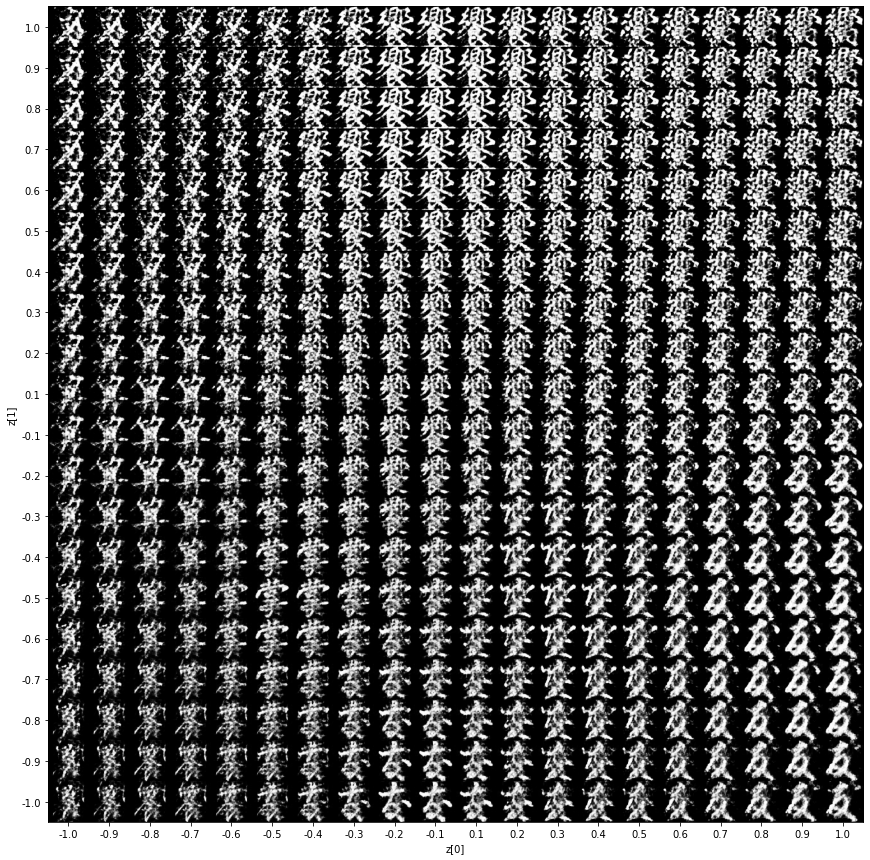

In [35]:
plot_latent_space(vae2, n=20)

Отже, ми побачили, що варіаційні автокодери здатні генерувати зображеня. Ми створили варіаційний автокодер Keras за допомогою Python і створили модель для генерації правдоподібних зображень з датасету kuzushiji-kanji. Звісно результат не такий як у DALL-E, але також доволі непоганий.